# FITTING A BOND YIELD CURVE

In this notebook I show how you can build a yield curve and fit it parametrically using a number of curve functions

In [1]:
import datetime as dt
import pandas as pd

In [10]:
from financepy.finutils.FinDayCount import FinDayCountTypes
from financepy.finutils.FinDate import FinDate, fromDatetime
from financepy.products.bonds.FinBond import FinBond
from financepy.products.bonds.FinBondMarket import getTreasuryBondMarketConventions, FinBondMarkets
from financepy.market.curves.FinBondYieldCurve import FinBondYieldCurve
from financepy.market.curves.FinBondYieldCurveModel import *

## Load Bond Data

I have downloaded some bond price data from the UK DMO

In [3]:
bondDataFrame = pd.read_csv('./data/giltbondprices.txt', sep='\t')

We'll use mid-market prices for our analysis

In [4]:
bondDataFrame['mid'] = 0.5*(bondDataFrame['bid'] + bondDataFrame['ask'])

We need to use UK bond conventions

In [5]:
accrualType, frequencyType, settlementDays = getTreasuryBondMarketConventions(FinBondMarkets.UNITED_KINGDOM)

In [6]:
today = FinDate(18,9,2012)
settlementDate = today.addWorkDays(settlementDays)
print("Settles:", settlementDate)

Settles: WED 19 SEP 2012


In [7]:
bonds = []
ylds = []

In [11]:
for index, bond in bondDataFrame.iterrows():

    dateString = bond['maturity']
    matDatetime = dt.datetime.strptime(dateString, '%d-%b-%y')
    maturityDt = fromDatetime(matDatetime)
    coupon = bond['coupon']/100.0
    cleanPrice = bond['mid']
    bond = FinBond(maturityDt, coupon, frequencyType, accrualType)
    yld = bond.yieldToMaturity(settlementDate, cleanPrice)
    bonds.append(bond)
    ylds.append(yld)

## Yield Curve Fitting

### Cubic Polynomial Curve

We can fit the yields to a polynomial. The default is a cubic so no argument is needed. 

In [12]:
curveFunction = FinCurveFitPolynomial()

In [13]:
fittedCurve = FinBondYieldCurve(settlementDate, bonds, ylds, curveFunction)

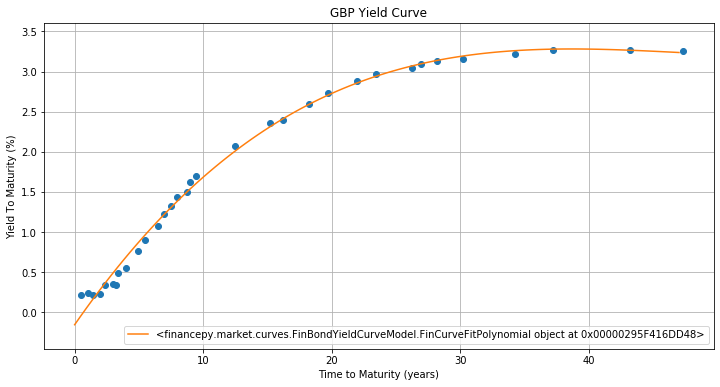

In [14]:
fittedCurve.plot("GBP Yield Curve")

We can get the coefficients as follows

In [15]:
curveFunction._coeffs

array([ 3.54399523e-07, -5.03888614e-05,  2.30700553e-03, -1.54434702e-03])

These coefficients start with the highest power of the time to maturity and end with the constant 

To get a specific yield we can call the function interpolatedYield

In [16]:
fittedCurve.interpolatedYield(20.0)*100

2.7275415160740595

In [17]:
times = np.linspace(0,10,10)

In [18]:
fittedCurve.interpolatedYield(times)*100

array([-0.1544347 ,  0.09572701,  0.33373872,  0.55989211,  0.77447886,
        0.97779067,  1.17011921,  1.35175619,  1.52299328,  1.68412216])

### Quintic Polynomial

We can add more parameters using a Quintic polynomial.

In [19]:
curveFunction = FinCurveFitPolynomial(5)

In [20]:
fittedCurve = FinBondYieldCurve(settlementDate, bonds, ylds, curveFunction)

In [21]:
curveFunction._coeffs

array([-1.45252099e-09,  1.78869307e-07, -7.42943959e-06,  9.07424916e-05,
        1.35450478e-03,  4.15140087e-07])

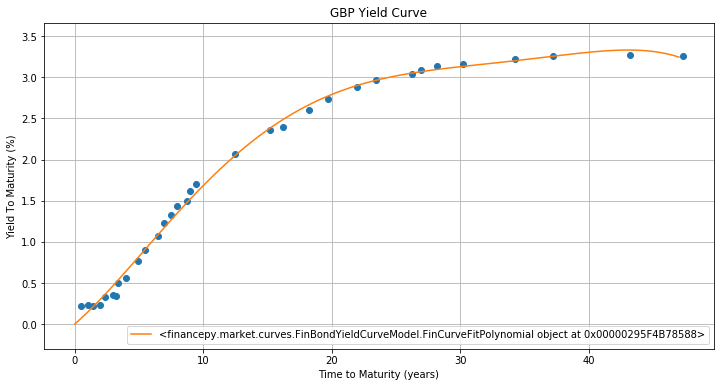

In [22]:
fittedCurve.plot("GBP Yield Curve")

The fit is slightly better.

Vectorisation works

In [23]:
fittedCurve.interpolatedYield(times)*100

array([4.15140087e-05, 1.60752711e-01, 3.38128992e-01, 5.27000145e-01,
       7.22791219e-01, 9.21493012e-01, 1.11963255e+00, 1.31424355e+00,
       1.50283696e+00, 1.68337135e+00])

### Nelson-Siegel Parametric Curve

We can fit the bond yields using the Nelson-Siegel curve

In [24]:
curveFunction = FinCurveFitNelsonSiegel()

In [25]:
fittedCurve = FinBondYieldCurve(settlementDate, bonds, ylds, curveFunction)

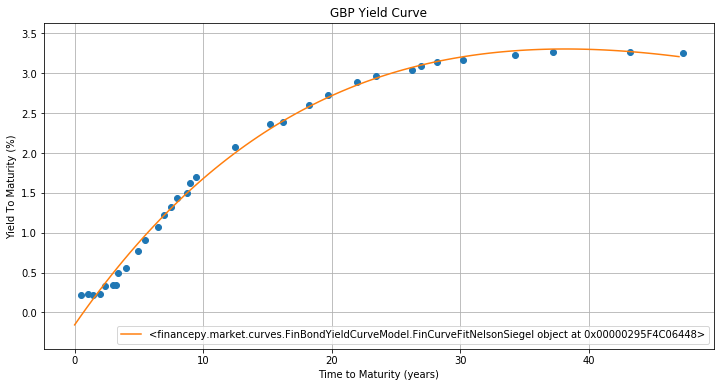

In [26]:
fittedCurve.plot("GBP Yield Curve")

We can access the underlying Nelson-Siegel parameters

In [27]:
print("beta1 %12.8f"% curveFunction._beta1)
print("beta2 %12.8f"% curveFunction._beta2)
print("beta3 %12.8f"% curveFunction._beta3)
print("tau   %12.8f"% curveFunction._tau)

beta1  -0.09365251
beta2   0.09210739
beta3   0.25879153
tau    35.76211678


Vectorisation works

In [28]:
fittedCurve.interpolatedYield(times)*100

array([-0.15510647,  0.09766686,  0.33665836,  0.56294964,  0.77701165,
        0.97929942,  1.17025258,  1.35029585,  1.51983957,  1.67928008])

### Nelson-Siegel-Svensson Parametric Curve

There are two more parameters in this parametric curve.

In [29]:
curveFunction = FinCurveFitNelsonSiegelSvensson()

In [30]:
fittedCurve = FinBondYieldCurve(settlementDate, bonds, ylds, curveFunction)

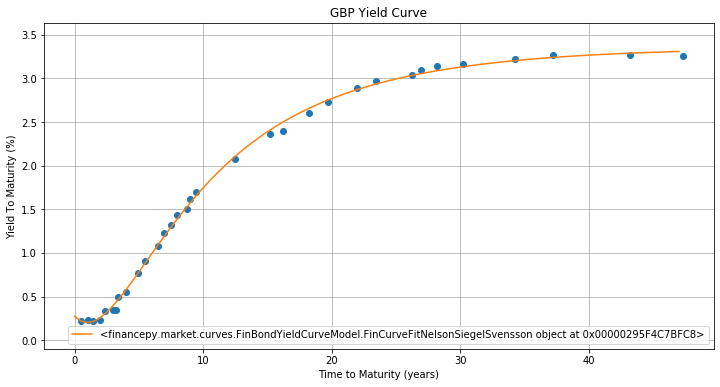

In [31]:
fittedCurve.plot("GBP Yield Curve")

Once again we can access the parameters

In [32]:
print("beta1 %12.8f"% curveFunction._beta1)
print("beta2 %12.8f"% curveFunction._beta2)
print("beta3 %12.8f"% curveFunction._beta3)
print("beta4 %12.8f"% curveFunction._beta4)
print("tau1  %12.8f"% curveFunction._tau1)
print("tau2  %12.8f"% curveFunction._tau2)

beta1   0.04601728
beta2  -0.04327119
beta3  -0.05225981
beta4  -0.03757521
tau1    3.17531649
tau2  100.00000000


Internally I have imposed a bound of [1,100] on tau2. I can override this. This is what is used internally.

In [33]:
bounds = [(0, -1, -1, -1, 0, 1), (1, 1, 1, 1, 10, 100)]

I change it to

In [34]:
bounds = [(0, -1, -1, -1, 0, 1), (1, 1, 1, 1, 10, 1000)]

In [35]:
curveFunction = FinCurveFitNelsonSiegelSvensson(bounds=bounds)

In [36]:
fittedCurve = FinBondYieldCurve(settlementDate, bonds, ylds, curveFunction)

In [37]:
print("beta1 %12.8f"% curveFunction._beta1)
print("beta2 %12.8f"% curveFunction._beta2)
print("beta3 %12.8f"% curveFunction._beta3)
print("beta4 %12.8f"% curveFunction._beta4)
print("tau1  %12.8f"% curveFunction._tau1)
print("tau2  %12.8f"% curveFunction._tau2)

beta1   0.04429960
beta2  -0.04153426
beta3  -0.05107487
beta4  -0.22576673
tau1    3.13203865
tau2  999.99999876


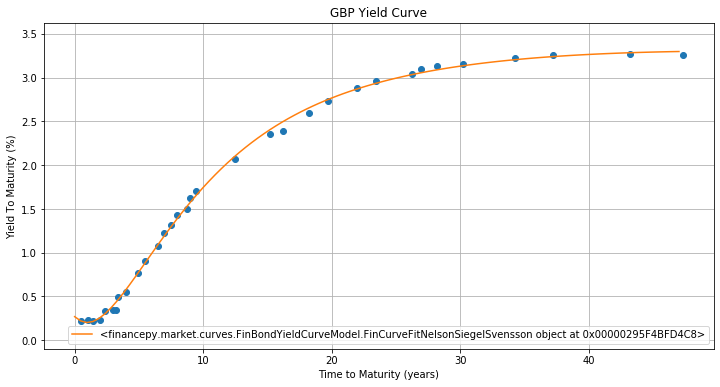

In [38]:
fittedCurve.plot("GBP Yield Curve")

It is clear that the parameter tau2 wants to head to infinity - reducing to the Nelson-Siegel parametrisation.

Vectorisation works

In [39]:
fittedCurve.interpolatedYield(times)*100

array([0.26950272, 0.20312856, 0.28501777, 0.45463165, 0.66846907,
       0.89912208, 1.12985211, 1.35091774, 1.55710142, 1.74605442])

### B-Splines

Splines give us more flexibility and ensure smoothness. Internally I put knots at 1, 3, 5 and 10 years. 

In [40]:
curveFunction = FinCurveFitBSpline()
fittedCurve = FinBondYieldCurve(settlementDate, bonds, ylds, curveFunction)

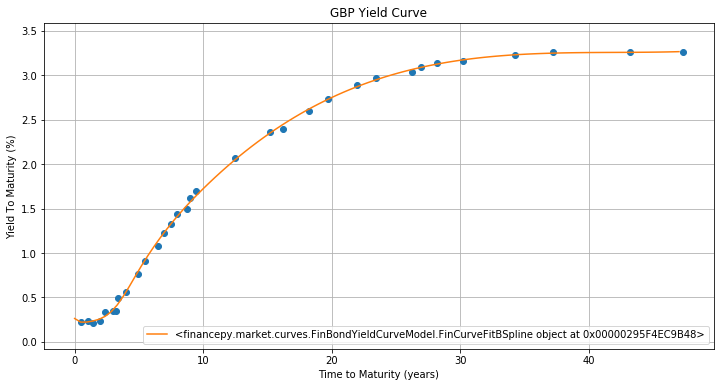

In [41]:
fittedCurve.plot("GBP Yield Curve")

We can recover the parameters of the spline.

In [42]:
curveFunction._spline

(array([ 0.46270692,  0.46270692,  0.46270692,  0.46270692,  1.        ,
         3.        ,  5.        , 10.        , 47.34121487, 47.34121487,
        47.34121487, 47.34121487]),
 array([0.00221936, 0.00216224, 0.00232291, 0.00280765, 0.01103459,
        0.03530528, 0.03212104, 0.03266754, 0.        , 0.        ,
        0.        , 0.        ]),
 3)

Vectorisation works.

In [43]:
fittedCurve.interpolatedYield(times)*100

array([0.26247922, 0.22601784, 0.27466458, 0.41879578, 0.67071265,
       0.93843591, 1.17276109, 1.37758332, 1.5591064 , 1.72353416])

You can change the power of the spline

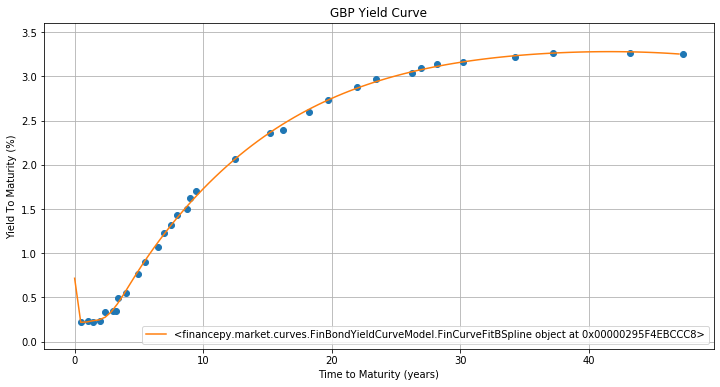

In [44]:
curveFunction = FinCurveFitBSpline(4)
fittedCurve = FinBondYieldCurve(settlementDate, bonds, ylds, curveFunction)
fittedCurve.plot("GBP Yield Curve")

This may not be what you want ! Let's see if 5 is better.

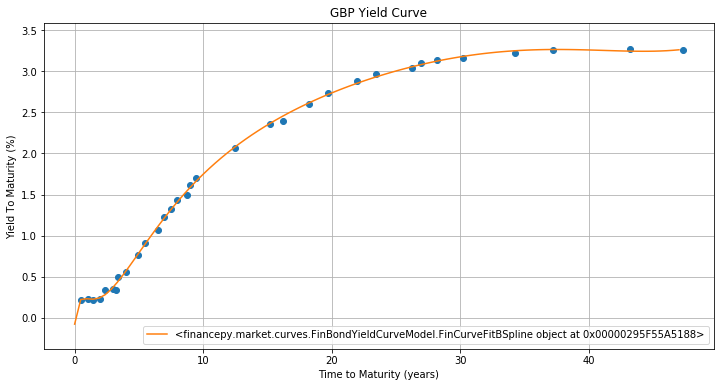

In [45]:
curveFunction = FinCurveFitBSpline(5)
fittedCurve = FinBondYieldCurve(settlementDate, bonds, ylds, curveFunction)
fittedCurve.plot("GBP Yield Curve")

Probably best to stick with a cubic B-spline.

## Inspecting the curve object


For each curve type you can examine the inner details of the calibration

In [47]:
fittedCurve._curveFit._knots

[1, 3, 5, 10]

In [53]:
fittedCurve._curveFit._power

5

In [54]:
fittedCurve._curveFit._spline

(array([ 0.46270692,  0.46270692,  0.46270692,  0.46270692,  0.46270692,
         0.46270692,  1.        ,  3.        ,  5.        , 10.        ,
        47.34121487, 47.34121487, 47.34121487, 47.34121487, 47.34121487,
        47.34121487]),
 array([0.00221936, 0.00237133, 0.0023876 , 0.00171554, 0.00506514,
        0.02909382, 0.0270327 , 0.03659002, 0.03131557, 0.03266729,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 5)

Copyright (c) 2019, Dominic O'Kane 